# Assignment: Animal Pose Estimation

## 1. Import required libraries
We start by importing all the necessary libraries for data handling, visualization, and model building.



In [37]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import drive
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Reshape

import albumentations as A
import seaborn as sns
import pandas as pd
import cv2 as cv

## 2. Load Dataset Keypoints
Mount Google Drive to access the dataset, and load the keypoints from the JSON file provided in the dataset.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMG_PATH = "/content/drive/MyDrive/Homeworks/Mod 10/Animal Pose Estimation/images/images"
with open('/content/drive/MyDrive/Homeworks/Mod 10/Animal Pose Estimation/keypoints.json', 'r') as f:
    keypoints = json.load(f)

In [4]:
keypoints.keys()

dict_keys(['images', 'annotations', 'categories', 'info'])

## 3. Exploratory Analysis
Exploratory analysis helps understand the underlying data to extract valuable insights. We compare the image distribution across each category and estimate the color frequency within each category to detect possible biases and understand the diversity of the dataset.

### Auxiliary Functions
Funtions to be used in one or multiple cells

In [6]:
def calc_avg_hist(images, category):
  color = ('b','g','r')
  hists = {
    "r":[],
    "g":[],
    "b":[]
  }
  for img in images:
    for i,col in enumerate(color):
        histr = cv.calcHist([img],[i],None,[256],[0,256])
        hists[col].append(histr)
  avg_r = np.mean(hists["r"], axis=0)
  avg_g = np.mean(hists["g"], axis=0)
  avg_b = np.mean(hists["b"], axis=0)
  return avg_r, avg_g, avg_b, category

def display_hist(avg_r, avg_g, avg_b, category):
  plt.figure()
  plt.title(category)
  plt.xlabel("Bins")
  plt.ylabel("# of Pixels")
  plt.plot(avg_r, color="red")
  plt.plot(avg_g, color="green")
  plt.plot(avg_b, color="blue")
  plt.xlim([0, 256])
  plt.show()

def process_data(dataframe, img_dir, target_size):
    images = []
    keypoints = []

    for index, row in dataframe.iterrows():
        img_path = f"{img_dir}/{row['image_path']}"
        img = load_img(img_path, target_size=target_size)  # Resize images to a fixed size
        img_array = img_to_array(img) / 255.0  # Normalize the image
        images.append(img_array)
        kp = np.array(row['keypoints'])
        normalized_keypoints = [
            (x / target_size[0], y / target_size[1])
            for x, y, v in kp
        ]
        keypoints.append(np.array(normalized_keypoints).flatten())

    return np.array(images), np.array(keypoints)

def process_keypoints(keypoints):
    # Only include keypoints where the visibility flag is 1
    visible_keypoints = [kp[:2] for kp in keypoints]
    return np.array(visible_keypoints).flatten()

### Categorical Distribution

#### List Categories
First, let's list all categories and their respective indexes.



In [7]:
keypoints["annotations"][:1]

[{'image_id': 1,
  'bbox': [123, 115, 379, 275],
  'keypoints': [[193, 216, 1],
   [160, 217, 1],
   [174, 261, 1],
   [204, 186, 1],
   [152, 182, 1],
   [0, 0, 0],
   [0, 0, 0],
   [273, 168, 1],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [266, 225, 1],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [190, 145, 1],
   [351, 238, 1]],
  'num_keypoints': 20,
  'category_id': 1}]

In [8]:
labels = [(keypoint["name"], keypoint["id"]) for keypoint in keypoints["categories"]]
labels_df = pd.DataFrame(labels, columns=["name", "idx"])

#### Image distribution per category
We load the (image, category) pair into a pandas DataFrame to facilitate handling of the keypoints dataset.

In [10]:
image_category_arr = []

for annotation in keypoints["annotations"]:
  img_name = keypoints["images"][str(annotation["image_id"])]
  image_category_arr.append((img_name, annotation["category_id"], annotation["keypoints"], annotation["bbox"]))

In [12]:
image_categ_df = pd.DataFrame(image_category_arr, columns=["image_path", "category_idx", "keypoints", "bbox"])
image_categ_df = image_categ_df.merge(labels_df, left_on='category_idx', right_on="idx").drop(columns=["idx"])
image_categ_df

,image_path,category_idx,keypoints,bbox,name
0,2007_000063.jpg,1,"[[193, 216, 1], [160, 217, 1], [174, 261, 1], ...","[123, 115, 379, 275]",dog
1,2007_000720.jpg,1,"[[277, 134, 1], [255, 135, 1], [272, 148, 1], ...","[217, 118, 305, 263]",dog
2,2007_001225.jpg,1,"[[186, 255, 1], [133, 258, 1], [136, 290, 1], ...","[100, 212, 303, 414]",dog
3,2007_001239.jpg,1,"[[305, 79, 1], [282, 84, 1], [310, 109, 1], [3...","[108, 60, 320, 160]",dog
4,2007_001239.jpg,1,"[[270, 177, 1], [243, 166, 1], [236, 207, 1], ...","[228, 138, 381, 375]",dog
...,...,...,...,...,...
6112,ca95.jpeg,2,"[[119, 74, 1], [87, 80, 1], [99, 93, 1], [143,...","[1, 22, 193, 298]",cat
6113,ca96.jpeg,2,"[[167, 51, 1], [139, 51, 1], [149, 71, 1], [18...","[17, 0, 259, 222]",cat
6114,ca97.jpeg,2,"[[161, 92, 1], [131, 91, 1], [146, 105, 1], [1...","[55, 17, 287, 273]",cat
6115,ca98.jpeg,2,"[[148, 105, 1], [113, 100, 1], [126, 128, 1], ...","[26, 22, 194, 286]",cat


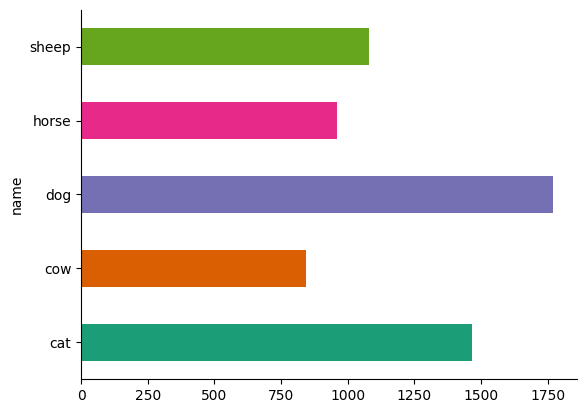

In [13]:
# @title Image x Category [bar]

from matplotlib import pyplot as plt
import seaborn as sns
image_categ_df.groupby('name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

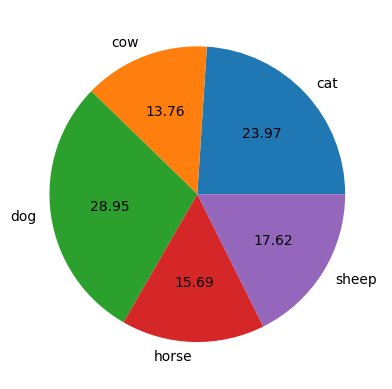

In [14]:
# @title Image x Category %
image_categ_df.groupby('name').size().plot.pie(autopct='%.2f')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [15]:
# @title Cows Image Number
image_categ_df[image_categ_df["name"] == "cow"]["name"].count()

842

From the output charts, we can see that the dataset is not equally divided. "Dog" is the most represented category, and cow is the least one with 842 images.

### Color Intensity and pixel distribution
We check the color distribution over a sample of each category.

#### Random Sample
Extract a sample of 10 images from each category for analysis.

In [16]:
random_samples = image_categ_df.groupby("category_idx").sample(n=10, random_state=1)
random_samples.head()

,image_path,category_idx,keypoints,bbox,name
434,2008_006452.jpg,1,"[[410, 152, 1], [274, 164, 1], [367, 218, 1], ...","[139, 15, 500, 290]",dog
194,2008_007344.jpg,1,"[[154, 175, 1], [147, 177, 1], [161, 186, 1], ...","[103, 161, 176, 225]",dog
1513,2011_001547.jpg,1,"[[146, 436, 1], [0, 0, 0], [123, 448, 1], [167...","[122, 395, 375, 500]",dog
1453,2010_005929.jpg,1,"[[116, 125, 1], [73, 107, 1], [85, 134, 1], [1...","[62, 31, 307, 273]",dog
1314,2010_004586.jpg,1,"[[254, 144, 1], [247, 142, 1], [247, 151, 1], ...","[241, 129, 307, 175]",dog


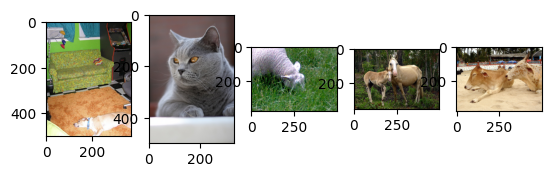

In [17]:
test_sample = random_samples.groupby("category_idx").sample(n=1, random_state=1)
f, axarr = plt.subplots(1,5)
count = 0

for index, row in test_sample.iterrows():
  test_img = cv.imread(f"{IMG_PATH}/{row['image_path']}")
  axarr[count].imshow(cv.cvtColor(test_img, cv.COLOR_BGR2RGB))
  count += 1

#### Extract RGB Courves
After defining the samples, extract the RGB curves and calculate the average curve for each category.


In [18]:
loaded_imgs = {}
for index, row in random_samples.iterrows():
  test_img = cv.imread(f"{IMG_PATH}/{row['image_path']}")
  if row["name"] not in loaded_imgs:
    loaded_imgs[row["name"]] = []
  loaded_imgs[row["name"]].append(test_img)

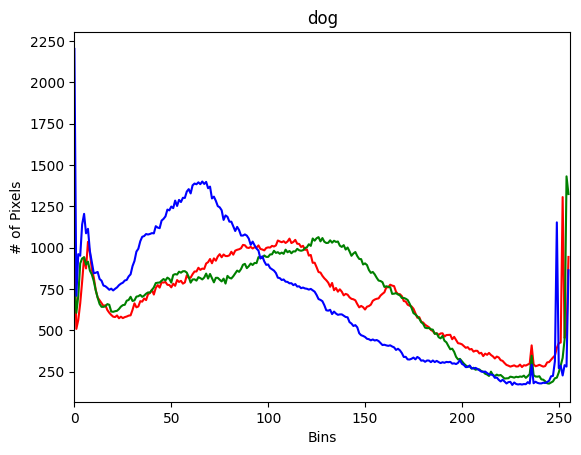

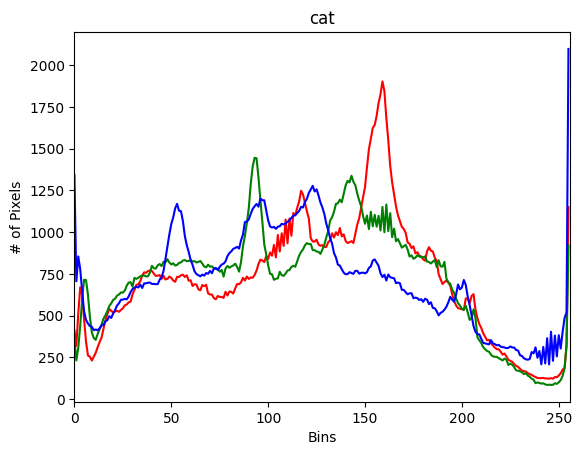

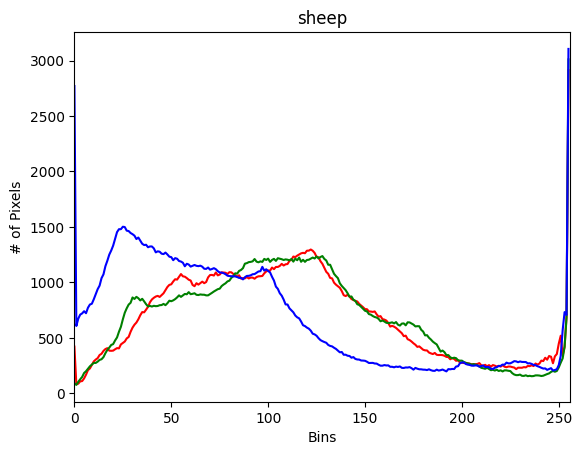

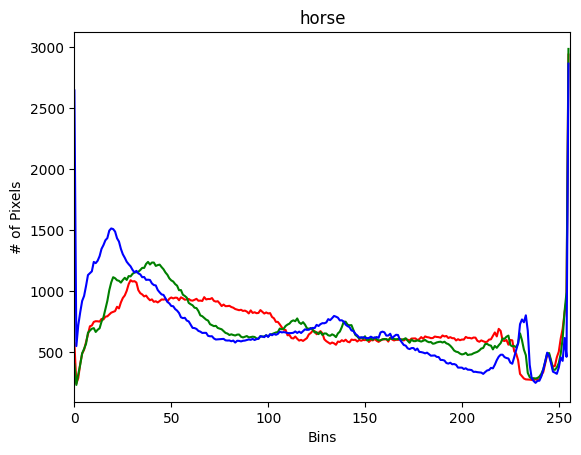

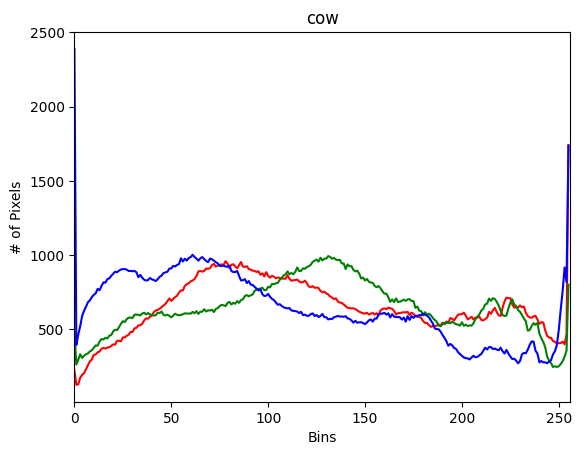

In [19]:
for category, images in loaded_imgs.items():
  r, g, b, categ = calc_avg_hist(loaded_imgs[category], category)
  display_hist(r,g,b, categ)

**Dog:** From the Dog Histogram, the blue channel shows a distinct peak around pixel value 50-100, suggesting that the dog images have a significant amount of dark blueish tones.
The red and green channels are more evenly distributed but still show some variation around the same region.

**Cat:** Cat images have noticeable peaks in the red and green channels around pixel value 150, indicating the presence of mid-range intensity colors, likely corresponding to common fur colors.

**Sheep:** The histograms for sheep images show a high peak in the blue channel at lower pixel values (around 50), suggesting darker blue tones, possibly from the background or shadowing in the images.
The red and green channels are more evenly distributed but still follow a similar pattern.

**Horse:** The horse images show a relatively balanced distribution across all channels

**Cow:** Cow images have peaks in the red and green channels around mid-range pixel values (100-150), which might be attributed to the common colors of cows and their surroundings.
The blue channel shows a broader distribution with peaks around the same region.

#### Color Distribution Insights
Dog: Significant amount of dark blueish tones.
Cat: Presence of mid-range intensity colors, likely corresponding to common fur colors.
Sheep: Darker blue tones, possibly from the background or shadowing in the images.
Horse: Relatively balanced distribution across all channels.
Cow: Peaks in the red and green channels around mid-range pixel values.


In [20]:
keypoints["categories"]

[{'supercategory': 'animal',
  'id': 1,
  'name': 'dog',
  'keypoints': ['left_eye',
   'right_eye',
   'nose',
   'left_ear',
   'right_ear',
   'left_front_elbow',
   'right_front_elbow',
   'left_back_elbow',
   'right_back_elbow',
   'left_front_knee',
   'right_front_knee',
   'left_back_knee',
   'right_back_knee',
   'left_front_paw',
   'right_front_paw',
   'left_back_paw',
   'right_back_paw',
   'throat',
   'withers',
   'tailbase'],
  'skeleton': [[0, 1],
   [0, 2],
   [1, 2],
   [0, 3],
   [1, 4],
   [2, 17],
   [18, 19],
   [5, 9],
   [6, 10],
   [7, 11],
   [8, 12],
   [9, 13],
   [10, 14],
   [11, 15],
   [12, 16]]},
 {'supercategory': 'animal',
  'id': 2,
  'name': 'cat',
  'keypoints': ['left_eye',
   'right_eye',
   'nose',
   'left_ear',
   'right_ear',
   'left_front_elbow',
   'right_front_elbow',
   'left_back_elbow',
   'right_back_elbow',
   'left_front_knee',
   'right_front_knee',
   'left_back_knee',
   'right_back_knee',
   'left_front_paw',
   'right_fron

## 4. Data Processing

### Filter Cows
Filter the dataset to include only cow images for the pose estimation model.

In [21]:
cows_dt = image_categ_df[image_categ_df["name"] == "cow"]
cows_dt.head()

,image_path,category_idx,keypoints,bbox,name
3809,2007_000464.jpg,5,"[[103, 269, 1], [86, 269, 1], [92, 284, 1], [1...","[71, 252, 216, 314]",cow
3810,2007_000464.jpg,5,"[[73, 225, 1], [0, 0, 0], [64, 240, 1], [84, 2...","[58, 202, 241, 295]",cow
3811,2007_000491.jpg,5,"[[0, 0, 0], [255, 46, 1], [308, 88, 1], [171, ...","[2, 2, 459, 334]",cow
3812,2007_000504.jpg,5,"[[363, 125, 1], [0, 0, 0], [343, 147, 1], [385...","[341, 102, 500, 406]",cow
3813,2007_000904.jpg,5,"[[248, 205, 1], [0, 0, 0], [238, 222, 1], [254...","[237, 167, 338, 263]",cow


### Check and store image resolution
Add width and height information to the Dataframe

In [22]:
import imagesize
for idx, row in cows_dt.iterrows():
  width, height = imagesize.get(IMG_PATH + "/" + "2007_000464.jpg")
  cows_dt.loc[idx, "w"] = width
  cows_dt.loc[idx, "h"] = height

<ipython-input-22-61ae2dd65e22>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cows_dt.loc[idx, "w"] = width
<ipython-input-22-61ae2dd65e22>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cows_dt.loc[idx, "h"] = height


In [23]:
cows_dt.head()

,image_path,category_idx,keypoints,bbox,name,w,h
3809,2007_000464.jpg,5,"[[103, 269, 1], [86, 269, 1], [92, 284, 1], [1...","[71, 252, 216, 314]",cow,375.0,500.0
3810,2007_000464.jpg,5,"[[73, 225, 1], [0, 0, 0], [64, 240, 1], [84, 2...","[58, 202, 241, 295]",cow,375.0,500.0
3811,2007_000491.jpg,5,"[[0, 0, 0], [255, 46, 1], [308, 88, 1], [171, ...","[2, 2, 459, 334]",cow,375.0,500.0
3812,2007_000504.jpg,5,"[[363, 125, 1], [0, 0, 0], [343, 147, 1], [385...","[341, 102, 500, 406]",cow,375.0,500.0
3813,2007_000904.jpg,5,"[[248, 205, 1], [0, 0, 0], [238, 222, 1], [254...","[237, 167, 338, 263]",cow,375.0,500.0


#### View Keypoints
Visualize keypoints on sample cow images.

<Figure size 800x600 with 0 Axes>

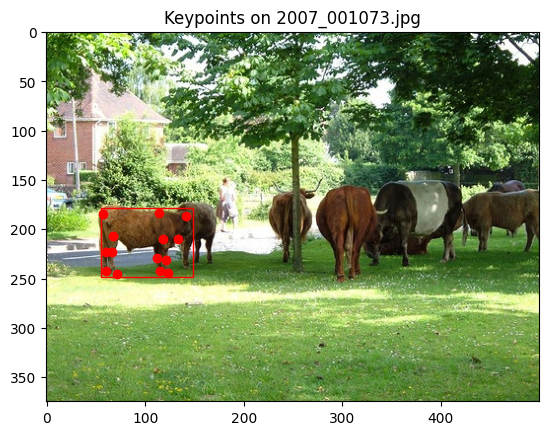

In [42]:
img_idx = 3814
test_img_path = IMG_PATH + "/" + cows_dt["image_path"][img_idx]
test_img = cv.imread(test_img_path)
test_img = cv.cvtColor(test_img, cv.COLOR_BGR2RGB)
keypoints = cows_dt["keypoints"][img_idx]

plt.figure(figsize=(8, 6))
fig, ax = plt.subplots()

ax.imshow(test_img)
for (x, y, v) in keypoints:
    if v == 1:
        plt.plot(x, y, 'ro')


x_min, y_min, x_max, y_max = cows_dt["bbox"][img_idx]
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.title(f"Keypoints on {cows_dt['image_path'][img_idx]}")
plt.show()

#### Augmentation / Processing Pipeline
Apply data augmentation techniques to the images and keypoints to improve model robustness.

In [67]:
transform = A.Compose([
    A.RandomCrop(width=200, height=200),
    A.RandomBrightnessContrast(p=0.2),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

<Figure size 800x600 with 0 Axes>

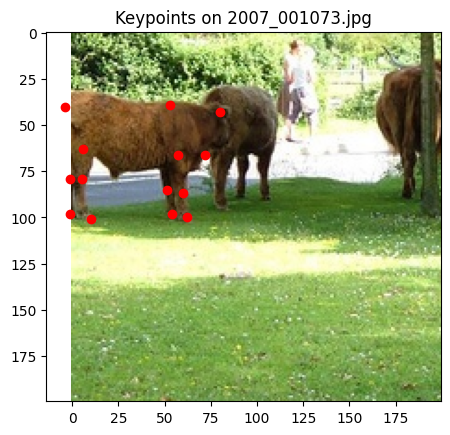

In [68]:
img_idx = 3814
test_img_path = IMG_PATH + "/" + cows_dt["image_path"][img_idx]
test_img = cv.imread(test_img_path)
test_img = cv.cvtColor(test_img, cv.COLOR_BGR2RGB)
keypoints = cows_dt["keypoints"][img_idx]
transformed = transform(image=test_img, keypoints=keypoints)

plt.figure(figsize=(8, 6))
fig, ax = plt.subplots()

ax.imshow(transformed['image'])
for (x, y, v) in transformed['keypoints']:
    if v == 1:
        plt.plot(x, y, 'ro')

plt.title(f"Keypoints on {cows_dt['image_path'][img_idx]}")
plt.show()

#### Results after processing pipeline
The preprocessing pipeline, which includes transformations such as random cropping and brightness adjustment, has noticeably impacted the images' histograms. This section details the changes observed in the histograms before and after processing.

1. Smoother Histograms: The histograms for each animal category have become smoother after applying the preprocessing pipeline. This indicates a more even distribution of pixel intensities across the images, suggesting that the transformations have mitigated sharp intensity variations.

2. Lower Peaks: The intensity peaks in the histograms are less pronounced after preprocessing. This reduction suggests that extreme brightness or darkness in certain regions of the images has been lessened, likely due to the brightness adjustment component of the pipeline.

3. Reduced Brightness and Highlights: There is a noticeable decrease in the number of extremely bright or highlighted areas in the images. The random cropping operation has contributed to this by removing portions of the image, particularly those with high brightness values, leading to a more balanced representation of pixel intensities.

In [69]:
loaded_imgs = {}
for index, row in random_samples.iterrows():
  test_img = cv.imread(f"{IMG_PATH}/{row['image_path']}")
  test_img_keypoints = row["keypoints"]
  if row["name"] not in loaded_imgs:
    loaded_imgs[row["name"]] = []
  loaded_imgs[row["name"]].append(transform(image=test_img, keypoints=test_img_keypoints))

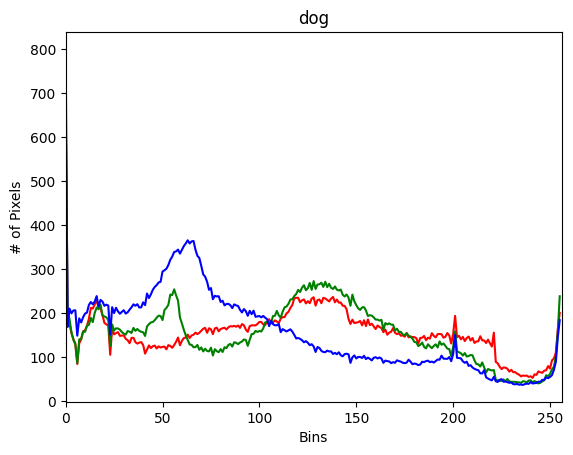

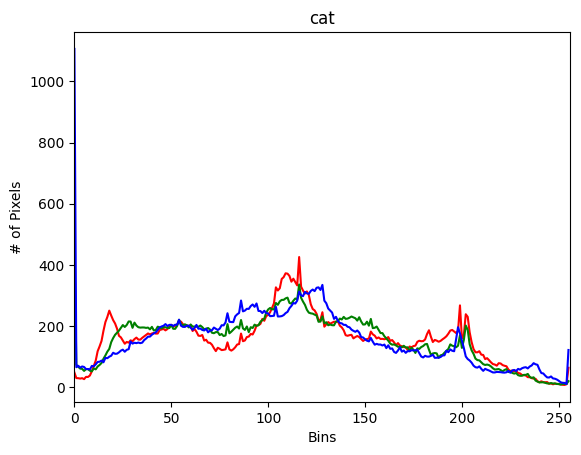

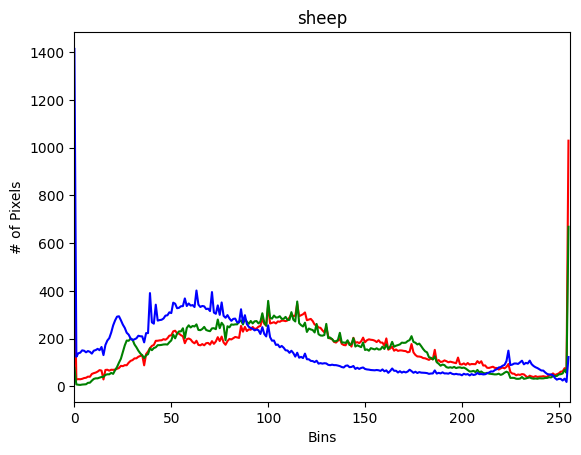

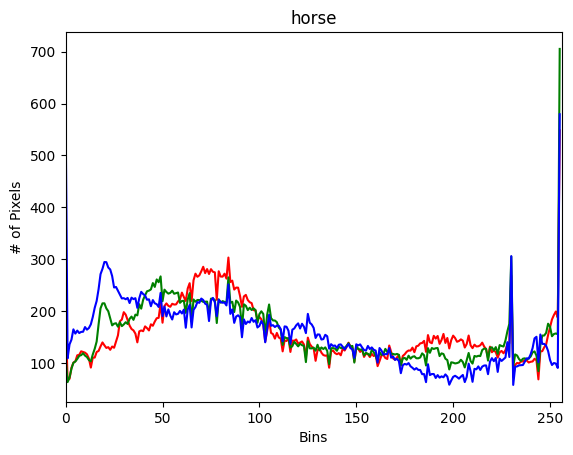

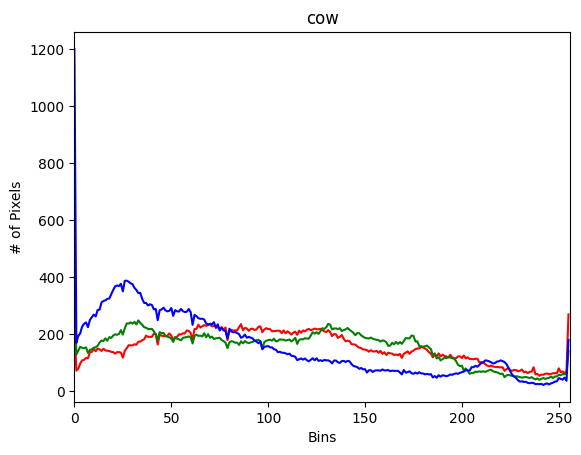

In [70]:
for category, images in loaded_imgs.items():
  imgs = [img["image"] for img in loaded_imgs[category]]
  r, g, b, categ = calc_avg_hist(imgs, category)
  display_hist(r,g,b, categ)

## 5. Model
In this section, we define and train a simple Convolutional Neural Network (CNN) for bovine pose estimation. The network architecture is designed to be straightforward yet effective for the task at hand. Here is the detailed description and implementation of the network:

### Divide Train - Test Dataset
Split the data into training and testing sets.

In [61]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_df, test_df = train_test_split(cows_dt, test_size=0.2, random_state=42)

# Print the size of training and testing sets
print(f'Training set size: {len(train_df)}')
print(f'Testing set size: {len(test_df)}')

Training set size: 673
Testing set size: 169


In [62]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Process the training and testing data
train_images, train_keypoints = process_data(train_df, IMG_PATH, (375, 500))
test_images, test_keypoints = process_data(test_df, IMG_PATH, (375, 500))

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# Define the simple CNN model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(375, 500, 3)))
model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 2
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 3
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output Layer (assuming 20 key points, each with x and y coordinates)
model.add(Dense(40, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Print the model summary
model.summary()

# Assuming train_images and train_keypoints are your training data and labels
# Train the model
history = model.fit(train_images, train_keypoints, epochs=2, batch_size=4, validation_data=(test_images, test_keypoints))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 373, 498, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 186, 249, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 184, 247, 16)      1168      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 92, 123, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 121, 32)       4640      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 45, 60, 32)       

This simple CNN consists of three convolutional layers, each followed by a max-pooling layer to reduce spatial dimensions and extract features. After flattening the feature maps, a fully connected layer with dropout is added to prevent overfitting. Finally, the output layer predicts the x and y coordinates for 20 key points (resulting in 40 output values).

## 6. Results | Training
Since the GPU model was unavailable, training was extremely slow. Two epochs were set as a sample of training results.

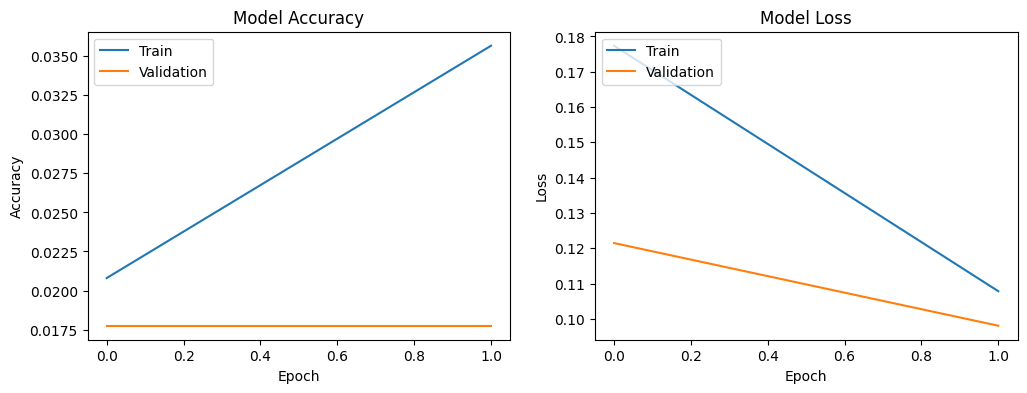

In [66]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

#### Inference Test

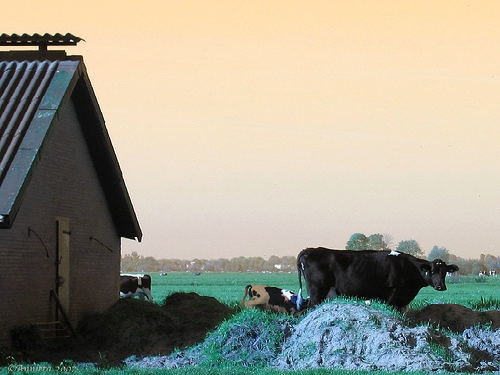

In [133]:
from google.colab.patches import cv2_imshow
predict_img = test_images[0]
predict_img_arr = np.expand_dims(predict_img, axis=0)
cv2_imshow(predict_img * 255)

In [134]:
predicted_keypoints = model.predict(predict_img_arr).flatten()

1/1 [==============================] - 0s 57ms/step


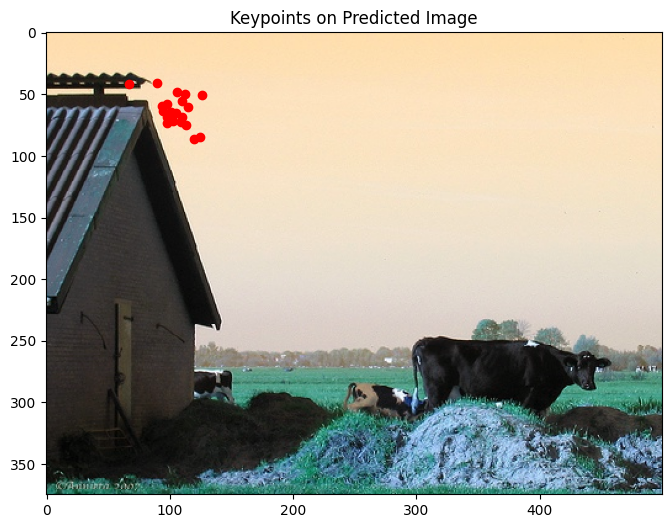

In [135]:
plt.figure(figsize=(8, 6))
plt.imshow(cv.cvtColor(predict_img, cv.COLOR_BGR2RGB))


for i in range(0, len(predicted_keypoints), 2):
    x = predicted_keypoints[i] * 500
    y = predicted_keypoints[i + 1] * 375
    plt.plot(x, y, 'ro')

plt.title(f"Keypoints on Predicted Image")
plt.show()

## 7. Conclusion
### Observations
The training accuracy showed a gradual increase over the epochs, indicating the model's learning process.
The validation accuracy remained constant and low, suggesting the model may be underfitting. From the predicted output, we can see that the model has not learned, and this could be due to multiple factors, ranging from network architecture to the actual dataset and processing steps.
### Limitations
Limited training duration due to computational constraints.
The simple CNN architecture might not be sufficient for the complex task of pose estimation.
### Future Work
Experiment with more complex architectures such as ResNet or MobileNet for improved performance.
Implement data augmentation techniques to enhance the training dataset.
Increase the number of training epochs and use a more powerful computational environment for training.
